<a href="https://colab.research.google.com/github/ziatdinovmax/GPim/blob/master/examples/notebooks/GP_EELS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Parallel" Gaussian process for Electron Energy Loss Spectroscopy (EELS) data



---


Application of "parallel GP" method for analysis of electron energy loss spectroscopy (EELS) data. The method operates on the full spatial domain and reduced representations in the energy
domain.


---





Notebook prepared by Sergei V. Kalinin and Maxim Ziatdinov (April 2020)

Install GPim from source:

(we use ```2>/dev/null``` so that we don't have to read Colab's complaints that torchaudio and torchtext versions don't match the torch version)

In [1]:
!pip install -q gpytorch==1.4.2  # we'll use gpytorch's IndexKernel
!python3 -m pip install -q git+https://github.com/ziatdinovmax/gpim 2>/dev/null  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 492 kB 5.3 MB/s 
  Attempting uninstall: gpytorch
    Found existing installation: gpytorch 1.5.1
    Uninstalling gpytorch-1.5.1:
      Successfully uninstalled gpytorch-1.5.1


Import needed modules:

In [1]:
import gpim
import numpy as np
from sklearn import decomposition
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

(Down)load data:

In [2]:
!wget -qq -O eels.npy "https://github.com/ziatdinovmax/GPim/blob/master/expdata/eels.npy?raw=true"
hdata = np.load("eels.npy")

The dataset is EELS data from LAO-STO obtained by Andrew Lupini (ORNL). 

Let's "flatten" the spatial dimensions of this dataset and normalize it for the decomposition analysis:

In [3]:
X_vec = hdata.copy()
d1, d2, d3 = X_vec.shape
X_vec = X_vec.reshape(d1*d2, d3)
X_vec = (X_vec - np.min(X_vec)) / np.ptp(X_vec)

We are now going to reduce the dataset in the energy dimension using the standard decomposition techniques such as principal component analysis (PCA) and non-negative matrix factorization (NMF). We can get an idea about how many PCA/NMF components are needed to describe the dataset using PCA scree plot:

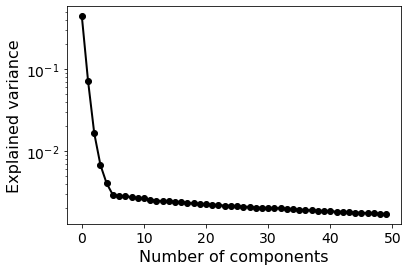

In [4]:
pca = decomposition.PCA()
pca.fit(X_vec)
plt.plot(pca.explained_variance_ratio_[0:50], '-o', linewidth=2, c='black')
plt.xlabel('Number of components', fontsize = 16)
plt.ylabel('Explained variance', fontsize = 16)
plt.tick_params(labelsize = 14)
plt.yscale("log")

Let's do decomposition for 12 components:

In [5]:
# Select number of components
nc = 12 
# Select decomposition type ('PCA' or 'NMF')
decomposition_type = 'NMF'

# Run decomposition
if decomposition_type == 'NMF':
    clf = decomposition.NMF(n_components=nc, random_state=42)
elif decomposition_type == 'PCA':
    clf = decomposition.PCA(n_components=nc, random_state=42)
else:
    raise NotImplementedError('Available methods: "PCA", "NMF"')
X_vec_t = clf.fit_transform(X_vec)
components = clf.components_
components = components.reshape(nc, d3)
print(components.shape, X_vec_t.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


(12, 1340) (2304, 12)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


Plot the decomposition results:

NUMBER OF COMPONENTS: 12
Components...


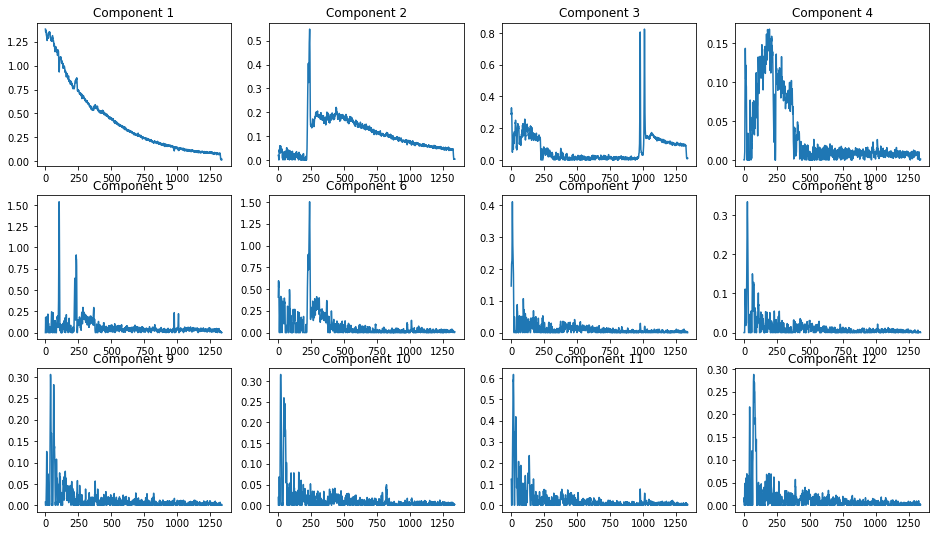

Abundance maps...


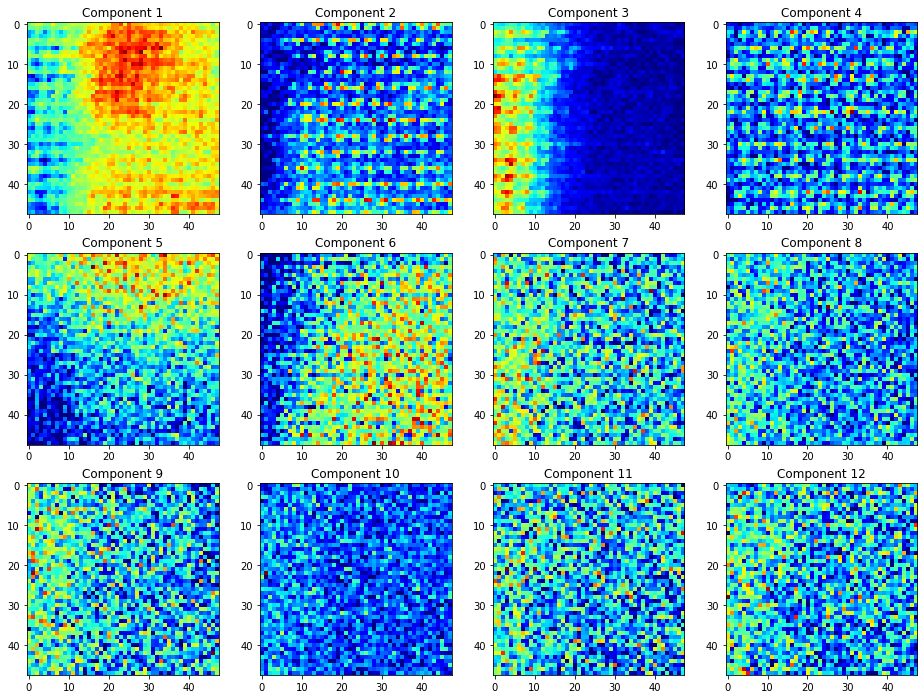

In [6]:
rows = int(np.ceil(float(nc)/5))
cols = int(np.ceil(float(nc)/rows))

print('NUMBER OF COMPONENTS: ' + str(nc))
print('Components...')
gs1 = gridspec.GridSpec(rows, cols)
fig1 = plt.figure(figsize = (4*cols, 3.5*(1+rows)//1.5))   
for i in range(nc):
    ax1 = fig1.add_subplot(gs1[i])
    j = 0
    ax1.plot(components[i])
    ax1.set_title('Component {}'.format(i + 1))
plt.show()

print('Abundance maps...')
gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))   
for i in range(nc):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(X_vec_t[:, i].reshape(d1, d2), cmap = 'jet')
    ax2.set_title('Component {}'.format(i + 1))
plt.show()

Based on the decompostions results we are going to perform "parallel" GP on the first 6 components. Here, the information between the components is shared via a common
spatial kernel structure while allowing for variability in the relative noise magnitude or image
morphology. For this, we are going to use model that learns a shared covariance function on
input-dependent features as first demonstrated [in this paper](https://papers.nips.cc/paper/3189-multi-task-gaussian-process-prediction.pdf).

In [7]:
Z = X_vec_t[:, :6].reshape(d1, d2, 6) # form an image stack with 6 components

grid_density = 2 # density of grid for prediction with a trained model 

X = gpim.utils.get_full_grid(Z[...,0], dense_x= 1) # training grid
Xtest = gpim.utils.get_full_grid(Z[...,0], dense_x=(1/grid_density)) # grid for prediction

# Train "parallel" GP:
vrec = gpim.vreconstructor(X, Z, Xtest, kernel='Matern52', 
                           lengthscale=[0.5, 2.5], isotropic=False,
                           learning_rate=0.05, iterations=200,
                           use_gpu=True, precision='double', verbose=2)

vrec.train()

Model training...
iter: 0 ... loss: 3021.7781 ... length: [1.525 1.525] ...
iter: 10 ... loss: 2517.3351 ... length: [1.7652 1.7652] ...
average time per iteration: 3.0469999999999997 s
iter: 20 ... loss: 1986.1336 ... length: [1.9642 1.9642] ...
iter: 30 ... loss: 1410.5242 ... length: [2.1076 2.1076] ...
iter: 40 ... loss: 789.2819 ... length: [2.2021 2.2022] ...
iter: 50 ... loss: 186.5456 ... length: [2.263  2.2631] ...
iter: 60 ... loss: -439.3894 ... length: [2.3052 2.3053] ...
iter: 70 ... loss: -1059.8562 ... length: [2.3357 2.3359] ...
iter: 80 ... loss: -1675.9973 ... length: [2.3588 2.359 ] ...
iter: 90 ... loss: -2276.1174 ... length: [2.3767 2.377 ] ...
iter: 100 ... loss: -2850.7532 ... length: [2.3908 2.3912] ...
iter: 110 ... loss: -3388.1627 ... length: [2.402  2.4027] ...
iter: 120 ... loss: -3871.1731 ... length: [2.4111 2.412 ] ...
iter: 130 ... loss: -4285.3672 ... length: [2.4182 2.4196] ...
iter: 140 ... loss: -4622.8855 ... length: [2.4238 2.4257] ...
iter: 150 

Make predcition with a trained model:

In [11]:
mean, sd = vrec.predict(Xtest)

Calculating predictive mean and uncertainty...
Batch 1/1
Done


Plot the results:

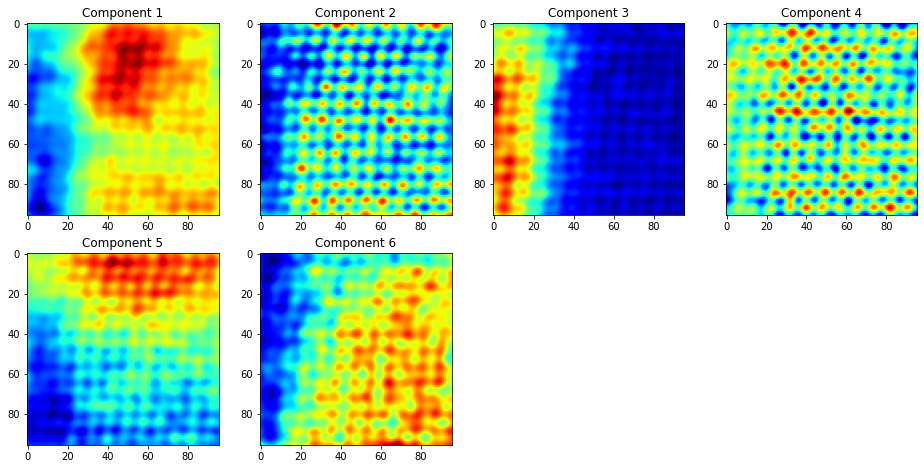

In [12]:
rows = int(np.ceil(float(nc)/5))
cols = int(np.ceil(float(nc)/rows))


gs2 = gridspec.GridSpec(rows, cols)
fig = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))  

for i in range(6):
    ax = fig.add_subplot(gs2[i])
    ax.imshow(mean[..., i].reshape(96, 96), cmap = 'jet')
    ax.set_title('Component ' + str(i + 1))
plt.show()

The "parallel" GP clearly allows us to reconstruct the atomic-scale features in these
components. However, analysis of a larger number of components does not lead to further
improvement. Using 7 components leads to partial degradation of contrast and then a full loss of
atomic periodicities for 8 components. This reveals that the model is effectively using
knowledge from the lower noise components in the reconstruction of the weaker signals. 